In [2]:
%cd ..

/Users/heilman/galvanize/recipe-vectorizer


In [43]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import pymongo
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from string import *
from src.functions import *
from src.modeling_functions import *
import imageio
import time
import warnings
warnings.filterwarnings("ignore")

In [101]:
recipes_coll = pymongo.MongoClient()['allrecipes']['recipes']
all_recipes = list(recipes_coll.find({'rating_info':{'$ne': None}}))
chili_recipes, chili_ratings = find_recipes_matching_search(recipes_coll, 'chili')

In [96]:
len(chili_recipes)

296

In [102]:
ratings = []
for rating in chili_ratings:
    ratings.append(rating['rating'])

In [103]:
chili_ratings = np.array(ratings)

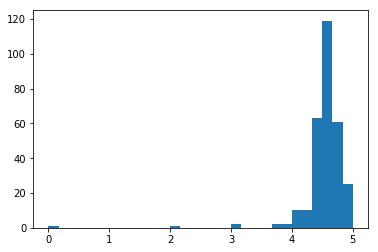

In [104]:
plt.hist(chili_ratings, bins=30);

In [19]:
len(ratings)

2570

In [18]:
df = create_dataframe(all_recipes, cutoff=5)
df.shape

(2570, 511)

In [105]:
chili_df = create_dataframe(chili_recipes, cutoff=5)
chili_df.shape

(296, 91)

In [106]:
X = chili_df.values
y = chili_ratings

In [21]:
X = df.values
y = ratings

In [22]:
kf = KFold(n_splits=10, shuffle=True)
models = []
for i, idxs in enumerate(kf.split(X)):
    print('Training fold {} of 10'.format(i+1))
    X_train = X[idxs[0]]
    y_train = y[idxs[0]]
    X_test = X[idxs[1]]
    y_test = y[idxs[1]]
    gbr = GradientBoostingRegressor(loss='ls',
                                    learning_rate=0.1,
                                    n_estimators=500,
                                    subsample=0.5,
                                    max_features='auto',
                                    max_depth=10)
    gbr.fit(X_train, y_train)
    models.append(gbr)

Training fold 1 of 10
Training fold 2 of 10
Training fold 3 of 10
Training fold 4 of 10
Training fold 5 of 10
Training fold 6 of 10
Training fold 7 of 10
Training fold 8 of 10
Training fold 9 of 10
Training fold 10 of 10


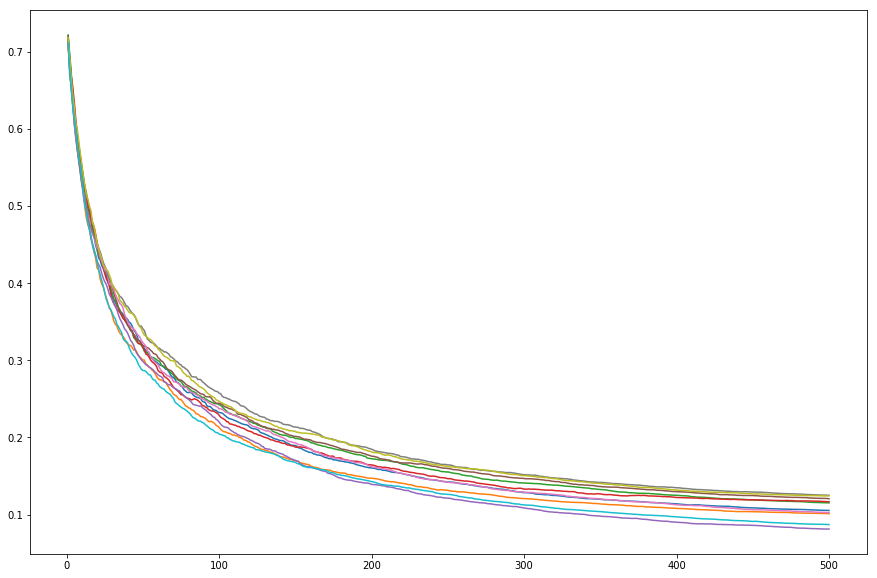

In [45]:
fig, ax = plt.subplots(figsize=(15,10))
for model in models:
    mse = []
    for y_preds in model.staged_predict(X):
        mse.append(mean_squared_error(y, y_preds))
    ax.plot(range(1, 501), mse)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=427)

In [ ]:
#### gbr = GradientBoostingRegressor(loss='ls',
                                learning_rate=0.001,
                                n_estimators=1000,
                                subsample=0.5,
                                #max_features='auto',
                                max_depth=)
gbr.fit(X_train, y_train)

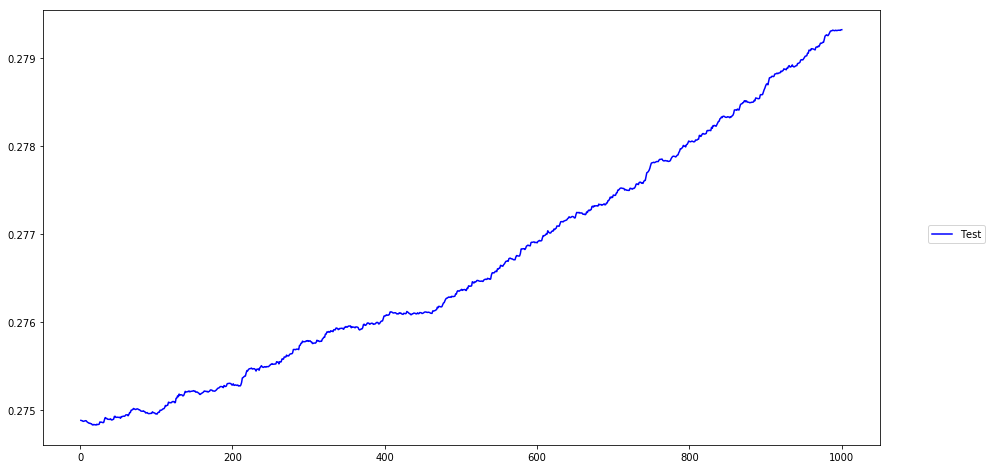

In [128]:
fig, ax = plt.subplots(figsize=(15,8))
train_mse = []
for y_preds in gbr.staged_predict(X_train):
    train_mse.append(mean_squared_error(y_train, y_preds))

test_mse = []
for y_preds in gbr.staged_predict(X_test):
    test_mse.append(mean_squared_error(y_test, y_preds))
#ax.plot(range(1, 1001), train_mse, color='r', label='Train')
ax.plot(range(1, 1001), test_mse, color='b', label='Test')
fig.legend(loc=7)

In [63]:
depths = [5, 10, 15, 20]
depth_cv_models = []
for depth in depths:
    gbr = GradientBoostingRegressor(loss='ls',
                                    learning_rate=0.05,
                                    n_estimators=500,
                                    subsample=0.5,
                                    max_features='auto',
                                    max_depth=depth)
    gbr.fit(X_train, y_train)
    depth_cv_models.append(gbr)

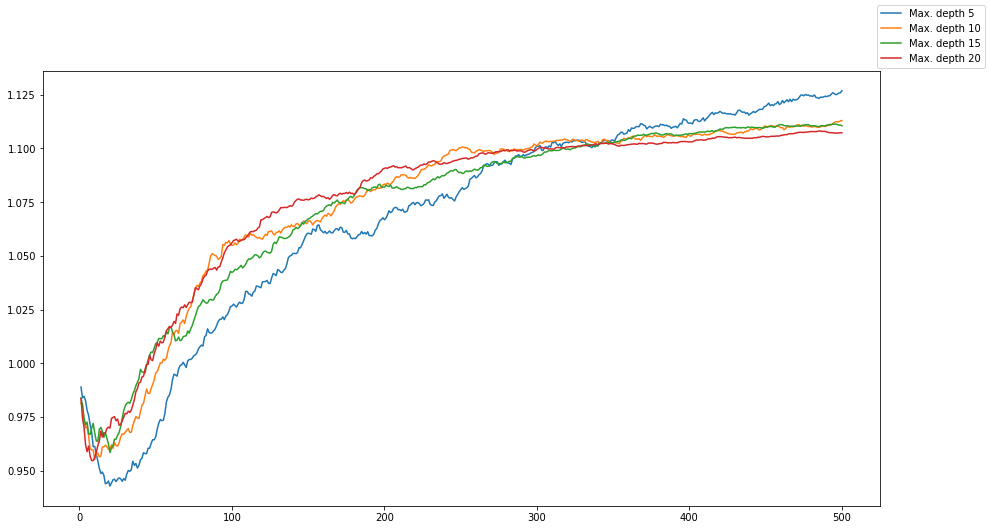

In [64]:
fig, ax = plt.subplots(figsize=(15,8))
depth_cv_test_mses = []
for depth, model in zip(depths, depth_cv_models):
    mse = []
    for y_preds in model.staged_predict(X_test):
        mse.append(mean_squared_error(y_test, y_preds))
    depth_cv_test_mses.append(mse)
    ax.plot(range(1, 501), mse, label='Max. depth {}'.format(depth))
fig.legend()

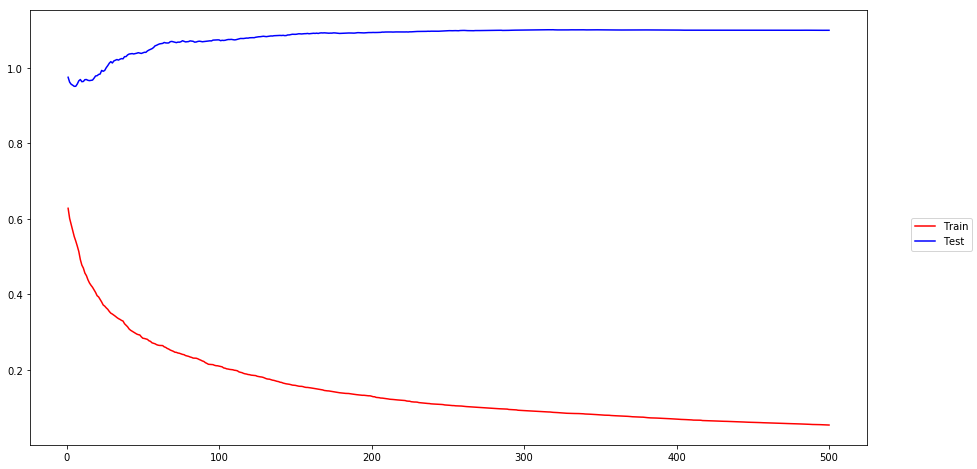

In [62]:
fig, ax = plt.subplots(figsize=(15,8))
train_mse = []
for y_preds in depth_cv_models[0].staged_predict(X_train):
    train_mse.append(mean_squared_error(y_train, y_preds))

test_mse = []
for y_preds in depth_cv_models[3].staged_predict(X_test):
    test_mse.append(mean_squared_error(y_test, y_preds))
ax.plot(range(1, 501), train_mse, color='r', label='Train')
ax.plot(range(1, 501), test_mse, color='b', label='Test')
fig.legend(loc=7)